In [1]:
import os
import zipfile
import string
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem.snowball import SnowballStemmer
from scipy.stats import uniform

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [3]:
sns.set(style='whitegrid')

## Unzip data

In [4]:
INPUT_PATH = 'data/input'
IMAGE_PATH = 'img'
zip_file = 'spooky-author-identification.zip'

In [5]:
for path in [INPUT_PATH, IMAGE_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
os.listdir(INPUT_PATH)

['sample_submission.csv', 'test.csv', 'train.csv']

In [7]:
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(INPUT_PATH)
#     os.remove()

In [8]:
os.listdir(INPUT_PATH)

['sample_submission.csv',
 'sample_submission.zip',
 'test.csv',
 'test.zip',
 'train.csv',
 'train.zip']

In [9]:
for filename in os.listdir(INPUT_PATH):
    if filename.endswith('.zip'):
        with zipfile.ZipFile(f'{INPUT_PATH}/{filename}', 'r') as zip_ref:
            zip_ref.extractall(INPUT_PATH)
        os.remove(f'{INPUT_PATH}/{filename}')

In [10]:
os.listdir(INPUT_PATH)

['sample_submission.csv', 'test.csv', 'train.csv']

## Read data

Dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. The objective is to accurately identify the author of the sentences.

In [11]:
df = pd.read_csv(f'{INPUT_PATH}/train.csv', index_col='id')

In [12]:
df.shape

(19579, 2)

### Data fields:

`id` - a unique identifier for each sentence

`text` - some text written by one of the authors

`author` - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)


In [13]:
df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


## Feature engineering and text processing

Do some feature engineering. This consists of two main parts.

    Meta features - features that are extracted from the text like number of words, number of stop words, number of punctuations etc
    Text based features - features directly based on the text / words like frequency, svd, word2vec etc

### Meta Features:

Lets start with creating meta featues . The feature list is as follows:

-    Number of characters
-    Number of words
-    Number and fraction of punctuation marks
-    Number and fraction of nouns
-    Number and fraction of adjectives
-    Number and fraction of verbs
-    Number and fraction of stopwords
-    Number and fraction of unique words

In [14]:
# lowercase
df['processed'] = df['text'].apply(lambda x: x.lower())

In [15]:
# count chars and words
df['n_chars'] = df['processed'].apply(lambda x: len(x))
df['n_words'] = df['processed'].apply(lambda x: len(x.split(' ')))

In [16]:
# count punctuation marks
df['n_punctuation'] = df['processed'].apply(lambda x: len([dig for dig in list(x) if dig in string.punctuation]))

In [17]:
# remove punctuation marks
df['processed'] = df['processed'].apply(lambda x: ''.join(ch for ch in x if ch not in string.punctuation))

In [18]:
df.head()

,text,author,processed,n_chars,n_words,n_punctuation
id,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,231,41,7
id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,71,14,1
id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,200,36,5
id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,206,34,4
id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,174,27,4


In [19]:
# count nouns, adjetives and verbs
nouns = ('NN','NNP','NNPS','NNS')
adjectives = ('JJ','JJR','JJS')
verbs = ('VB','VBD','VBG','VBN','VBP','VBZ')

df['n_noun'] = df['processed'].apply(lambda x: sum(np.in1d(np.array(pos_tag(word_tokenize(x)))[:,1], nouns)))
df['n_adj'] = df['processed'].apply(lambda x: sum(np.in1d(np.array(pos_tag(word_tokenize(x)))[:,1], adjectives)))
df['n_verb'] = df['processed'].apply(lambda x: sum(np.in1d(np.array(pos_tag(word_tokenize(x)))[:,1], verbs)))

In [20]:
# count stopwords
eng_stopwords = set(stopwords.words("english"))
df['n_stopwords'] = df['processed'].apply(lambda x: sum(np.in1d(word_tokenize(x), eng_stopwords)))

In [21]:
# unique words
df['n_unique'] = df['processed'].apply(lambda x: len(set(word_tokenize(x))))

In [22]:
# fractions

for count in ['n_noun', 'n_adj', 'n_verb', 'n_stopwords', 'n_unique']:
    df['fract'+count[1:]] = df[count] / df['n_words']
    
df['fract_punctuation'] = df['n_punctuation']/df['n_chars']

In [23]:
df.head()

,text,author,processed,n_chars,n_words,n_punctuation,n_noun,n_adj,n_verb,n_stopwords,n_unique,fract_noun,fract_adj,fract_verb,fract_stopwords,fract_unique,fract_punctuation
id,,,,,,,,,,,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,231,41,7,12,2,6,0,35,0.292683,0.048780,0.146341,0.0,0.853659,0.030303
id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,71,14,1,2,1,2,0,14,0.142857,0.071429,0.142857,0.0,1.000000,0.014085
id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,200,36,5,10,5,4,0,32,0.277778,0.138889,0.111111,0.0,0.888889,0.025000
id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,206,34,4,10,6,5,0,31,0.294118,0.176471,0.147059,0.0,0.911765,0.019417
id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,174,27,4,6,1,6,0,25,0.222222,0.037037,0.222222,0.0,0.925926,0.022989


## EDA

### Boxplots

Plot some of new variables to see if they are helpful to predict an author.

In [24]:
cols_plot = list(df.columns[df.columns.get_loc('n_chars'):])
len(cols_plot)

14

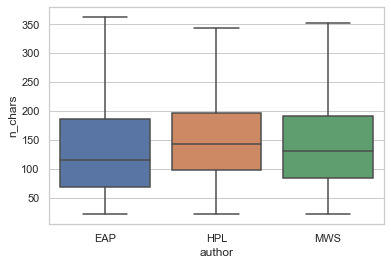

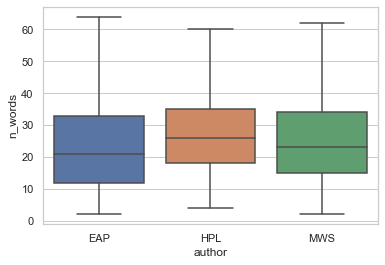

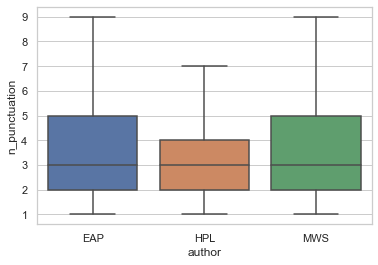

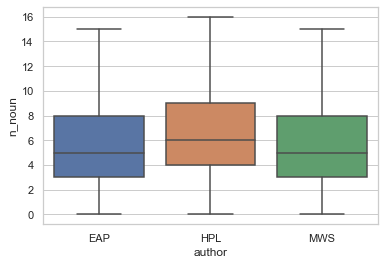

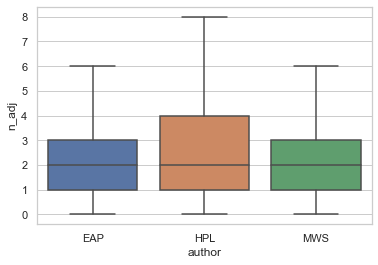

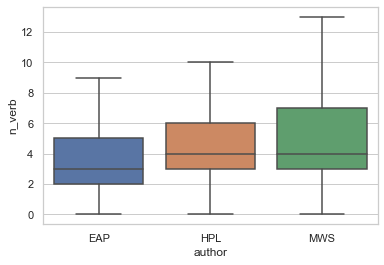

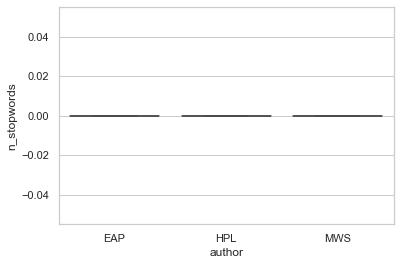

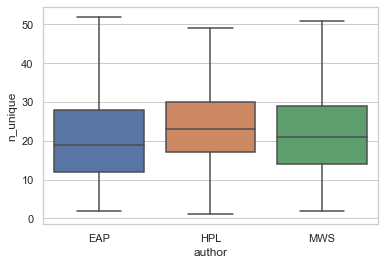

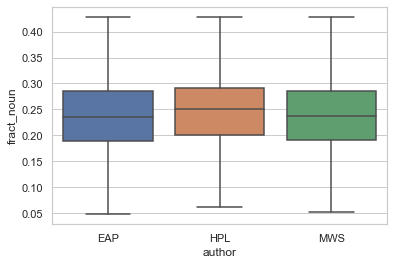

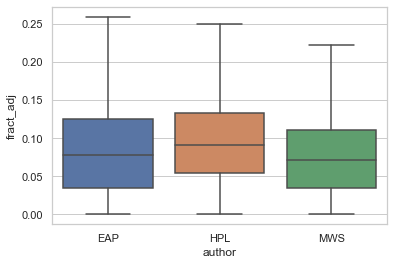

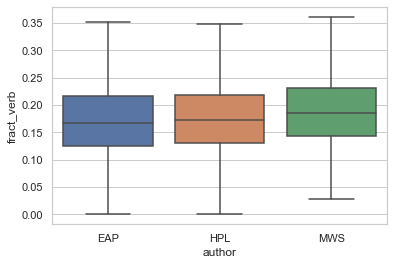

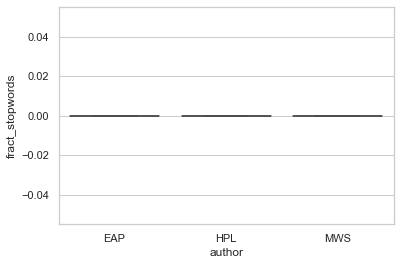

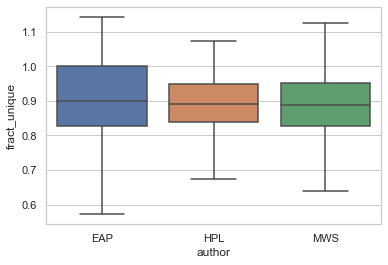

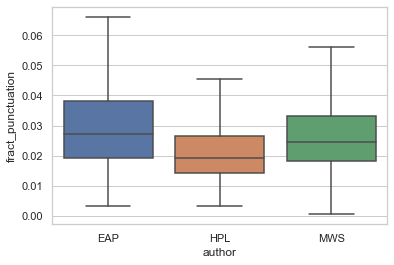

In [25]:
for col in list(cols_plot):
    sns.boxplot(x='author', y=col, data=df, showfliers=False)
    plt.show()
    plt.close()

It can be seen that number of nouns, adjectives and verbs, as well as punctuation fraction are slightly different for all authors.

### Wordcloud
Wordcloud helps us to see the most frequent words in the text in fascinating way. 
It seems to me that plotting wordcloud of all authors words together and then plotting it for each author would be a good idea. It may give us some hints of how to distinguish between authors by words frequancy only.

In [26]:
def show_word_cloud(s, author='', save=True):
    text = " ".join(review for review in s)
    # Create stopword list:
    stopwords = set(eng_stopwords)

    # Generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.figure(figsize=(13, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(author)
    plt.show()
    if save:
#         plt.savefig(f"img/word_cloud{author}.jpg", format="jpg",dpi=100)
        wordcloud.to_file(f"{IMAGE_PATH}/word_cloud{author}.png")
    plt.close()

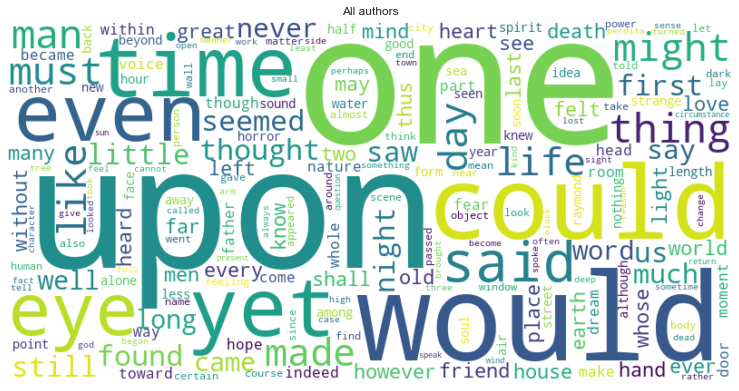

In [27]:
show_word_cloud(df['processed'], 'All authors')

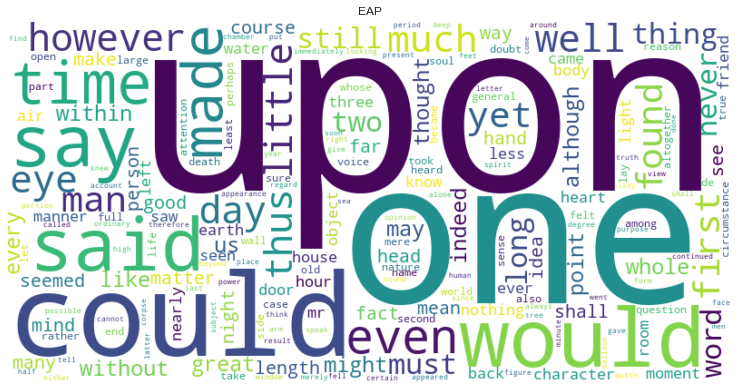

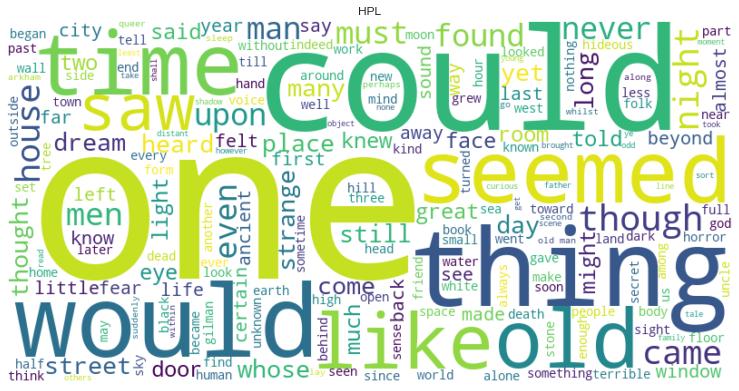

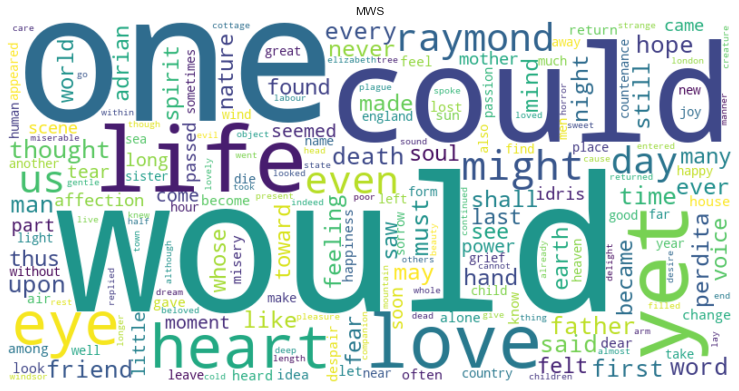

In [28]:
for author in df['author'].unique():
    show_word_cloud(df[df['author'] == author]['processed'], author)

## Stemming
In grammar, inflection is the modification of a word to express different grammatical categories such as tense, case, voice, aspect, person, number, gender, and mood. An inflection expresses one or more grammatical categories with a prefix, suffix or infix, or another internal modification such as a vowel change. 

__Stemming__ is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

Stem (root) is the part of the word to which you add inflectional (changing/deriving) affixes such as (-ed,-ize, -s,-de,mis). So stemming a word or sentence may result in words that are not actual words. Stems are created by removing the suffixes or prefixes used with a word.

In [29]:
stemmer=SnowballStemmer("english")

def stem(s):
    return ' '.join([stemmer.stem(word) for word in word_tokenize(s)])

%time df['processed'] = df['processed'].apply(lambda x: stem(x))

CPU times: user 5.61 s, sys: 0 ns, total: 5.61 s
Wall time: 5.61 s


In [30]:
df.head()

,text,author,processed,n_chars,n_words,n_punctuation,n_noun,n_adj,n_verb,n_stopwords,n_unique,fract_noun,fract_adj,fract_verb,fract_stopwords,fract_unique,fract_punctuation
id,,,,,,,,,,,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,this process howev afford me no mean of ascert...,231,41,7,12,2,6,0,35,0.292683,0.048780,0.146341,0.0,0.853659,0.030303
id17569,It never once occurred to me that the fumbling...,HPL,it never onc occur to me that the fumbl might ...,71,14,1,2,1,2,0,14,0.142857,0.071429,0.142857,0.0,1.000000,0.014085
id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,200,36,5,10,5,4,0,32,0.277778,0.138889,0.111111,0.0,0.888889,0.025000
id27763,How lovely is spring As we looked from Windsor...,MWS,how love is spring as we look from windsor ter...,206,34,4,10,6,5,0,31,0.294118,0.176471,0.147059,0.0,0.911765,0.019417
id12958,"Finding nothing else, not even gold, the Super...",HPL,find noth els not even gold the superintend ab...,174,27,4,6,1,6,0,25,0.222222,0.037037,0.222222,0.0,0.925926,0.022989


## Train/test split

Simple 80/20 split

In [31]:
train_cols = list(df.columns[df.columns.get_loc('processed'):])
X, y = df[train_cols].copy(), df['author'].copy()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.copy()
X_test = X_test.copy()

## TF-IDF
In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

Tf means __term-frequency__ while tf–idf means term-frequency times __inverse document-frequency__.

In [33]:
tfidf = TfidfVectorizer(stop_words=eng_stopwords, min_df=3)
tfidf.fit(X_train['processed'])
X_train = np.concatenate([X_train, tfidf.transform(X_train['processed']).toarray()], axis=1)
X_test = np.concatenate([X_test, tfidf.transform(X_test['processed']).toarray()], axis=1)

In [34]:
X_train.shape

(15663, 7406)

In [35]:
# drop the first columns which is 'processed'
X_train, X_test = X_train[:, 1:], X_test[:, 1:]

## Model

### Naive Bayes
__Naive Bayes__ methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

__MultinomialNB__ implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). 

GridSearchCV is used to find optimal $\alpha$ for Naive Bayes Classificator.

In [36]:
gs = GridSearchCV(
    MultinomialNB(),
    param_grid = { 'alpha':(0.001, 0.01,0.05, 0.1, 0.5, 1, 10)},
    scoring='neg_log_loss',
    n_jobs = 1,
    cv=4,
    verbose=100,
    refit=True
)
gs.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-0.472, total=   1.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-0.496, total=   1.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-0.482, total=   1.9s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s
[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-0.495, total=   1.9s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

GridSearchCV(cv=4, estimator=MultinomialNB(), n_jobs=1,
             param_grid={'alpha': (0.001, 0.01, 0.05, 0.1, 0.5, 1, 10)},
             scoring='neg_log_loss', verbose=100)

In [37]:
nb = gs.best_estimator_
nb

MultinomialNB(alpha=0.05)

In [38]:
accuracy_score(y_test, nb.predict(X_test))

0.8215015321756894

### Random Forest

In [39]:
rf_params = dict(max_depth=710, max_features=0.0225716742746937,
                       max_samples=0.7091283290110244, min_samples_leaf=4,
                       min_samples_split=6)
rf_params['n_estimators'] = 200
rf_params['random_state'] = 42
rf_params['n_jobs'] = -1
rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=710, max_features=0.0225716742746937,
                       max_samples=0.7091283290110244, min_samples_leaf=4,
                       min_samples_split=6, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [40]:
accuracy_score(y_test, rf.predict(X_test))

0.6422369765066395

Unfortunately, even after tunning the score is low :(

### SVM

In [41]:
svm_pipe= Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC(max_iter=1200, random_state=42))
])

%time svm_pipe.fit(X_train, y_train)

CPU times: user 9min 36s, sys: 309 ms, total: 9min 36s
Wall time: 9min 37s


/home/daryna/anaconda3/envs/ml_ukma/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svm', SVC(max_iter=1200, random_state=42))])

In [42]:
accuracy_score(y_test, svm_pipe.predict(X_test))

0.7637895812053116

### Voting Classifier

Now lets ensemble Naive Bayes, Random Forest and SVM classifiers using Voting Classifier. 

P.S. Unfortunately, stacking leads to memory error, thus I can't use it :(

In [43]:
vote_clf = VotingClassifier(
    estimators = [
        ('nb', nb),
        ('rf', rf),
        ('svm', svm_pipe)
    ],
#     final_estimator=LogisticRegression(),
    n_jobs=-1,
#     cv=3,
#     verbose=10
)
vote_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('nb', MultinomialNB(alpha=0.05)),
                             ('rf',
                              RandomForestClassifier(max_depth=710,
                                                     max_features=0.0225716742746937,
                                                     max_samples=0.7091283290110244,
                                                     min_samples_leaf=4,
                                                     min_samples_split=6,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('svm',
                              Pipeline(steps=[('scaler', MinMaxScaler()),
                                              ('svm',
                                               SVC(max_iter=1200,
                                                   random_state=42))]))],
  

In [44]:
accuracy_score(y_test, vote_clf.predict(X_test))

0.8102655771195098

In [45]:
vote_clf.estimators_

[MultinomialNB(alpha=0.05),
 RandomForestClassifier(max_depth=710, max_features=0.0225716742746937,
                        max_samples=0.7091283290110244, min_samples_leaf=4,
                        min_samples_split=6, n_estimators=200, n_jobs=-1,
                        random_state=42),
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('svm', SVC(max_iter=1200, random_state=42))])]

In [46]:
for clf in [nb, rf, svm_pipe, vote_clf]:
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

MultinomialNB 0.8215015321756894
RandomForestClassifier 0.6422369765066395
Pipeline 0.7637895812053116
VotingClassifier 0.8102655771195098


In [47]:
df.shape

(19579, 17)

VotingClassifier does not show best results. Random Forest has quite low accuracy comparatively to Naive Bayes and SVM, which is likely to be the reason of Voting Classifier to behave this way.

## Summary

### 1. Text Processing.
    1) Lowercase
    2) Remove punctuation
    3) Remove stopwords
    4) Stemming
### 2. Feature Egineering. 
    - Meta features - number/fraction of words/characters
    - Text based features - tf-idf
### 3. Train/test split.
    Train on 80% of data and test on 20% of data.
### 4. Model
    - Naive Bayes------|
    - Random Forest----|===> VotingClassifier
    - SVM--------------|

### What else to try?
- word2vec (Bogdan mentioned it in his presentation)
- stacking (unfortunately not on this computer :( 
- cross validation
- removing Random Forest from ensemble